In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import tensorflow_hub as hub

In [21]:
IMAGE_SHAPE=(224,224,3)

In [22]:
classifier=tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE)
])

In [5]:
image_labels=[]
with open('../resources/ImageNetLabels.txt') as f:
    image_labels=f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [6]:
import pathlib
data_dir=pathlib.Path('../resources/datasets/flower_photos')
data_dir

WindowsPath('../resources/datasets/flower_photos')

In [23]:
flower_images_dict=dict()
for i in data_dir.iterdir():
    if i.is_dir():
        flower_images_dict[i.name]=flower_images_dict.get(i.name,list(i.glob("*"))[:100])

class_names=list(flower_images_dict.keys())

In [8]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

daisy


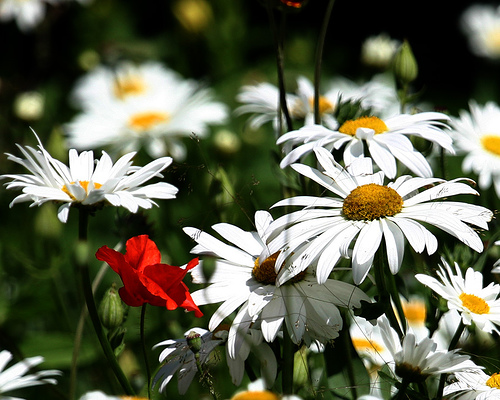

In [9]:
print(class_names[0])
Image.open(str(flower_images_dict[class_names[0]][5]))


In [24]:
X,y=[],[]

for flower_name,images in flower_images_dict.items():
    i=class_names.index(flower_name)
    for image in images:
        img=cv2.imread(str(image))
        reshaped_img=cv2.resize(img,(224,224))
        X.append(reshaped_img)
        y.append(i)
        
X=np.array(X)
y=np.array(y)

In [25]:
X_scaled=X/255

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,random_state=0,stratify=y)

In [31]:
predictions=tf.nn.softmax(classifier.predict(np.array(X_train[:5])))
predictions

1/1 [==============================] - 0s 282ms/step


<tf.Tensor: shape=(5, 1001), dtype=float32, numpy=
array([[3.4006819e-04, 1.2585585e-04, 1.7774104e-04, ..., 4.6648495e-04,
        6.2124338e-05, 1.3091962e-04],
       [2.7017840e-04, 1.8958197e-04, 1.7459280e-04, ..., 3.9396065e-04,
        3.2919219e-05, 3.9177150e-05],
       [2.5164729e-04, 4.6776982e-05, 4.1044637e-04, ..., 1.6886046e-05,
        2.6638189e-04, 6.2600226e-04],
       [4.8885442e-04, 8.9615532e-05, 7.2187808e-04, ..., 4.8974591e-05,
        2.9417407e-04, 3.2849962e-04],
       [2.4861887e-05, 2.4334604e-05, 1.0125465e-04, ..., 5.2335381e-06,
        5.0950439e-06, 7.0990936e-05]], dtype=float32)>

In [65]:
y_predicted=[image_labels[np.argmax(x)] for x in predictions]
y_predicted

['bee', 'sea anemone', 'pinwheel', 'head cabbage', 'vase']

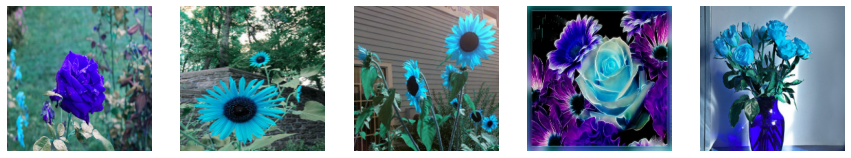

In [66]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 10))   
for i in range(5): 
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.axis("off")
    

In [71]:
feature_extractor_model="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_last_layer=hub.KerasLayer(
    feature_extractor_model,input_shape=IMAGE_SHAPE,trainable=False)

In [72]:
model=tf.keras.Sequential([
    pretrained_model_without_last_layer,
    tf.keras.layers.Dense(len(class_names))
    
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [74]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history=model.fit(X_train,y_train,epochs=5)

Epoch 1/5
12/12 [==============================] - 33s 1s/step - loss: 1.6809 - accuracy: 0.2827
Epoch 2/5
12/12 [==============================] - 16s 1s/step - loss: 0.9922 - accuracy: 0.6480
Epoch 3/5
12/12 [==============================] - 17s 1s/step - loss: 0.6934 - accuracy: 0.7653
Epoch 4/5
12/12 [==============================] - 17s 1s/step - loss: 0.5372 - accuracy: 0.8400
Epoch 5/5
12/12 [==============================] - 16s 1s/step - loss: 0.4335 - accuracy: 0.8747


In [75]:
model.evaluate(X_test,y_test)

4/4 [==============================] - 7s 1s/step - loss: 0.5090 - accuracy: 0.8240


[0.5090078711509705, 0.8240000009536743]